# Section 1:  Libraries (added the last section)

In [11]:
# Import Libraries #
import json
from pprint import pprint
from pandas import *
from pandas.io.json import json_normalize

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# General libraries
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

# SK-learn libraries for pre/processing data
from sklearn import preprocessing

from sklearn.decomposition import LatentDirichletAllocation as LDA

# SK-learn libraries for learning
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# SK-learn libraries for evaluation
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

# Jen2's libraries
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt

# Section 2:  Loading (same)

In [2]:
## Get Data ##

#reference on data: https://www.kaggle.com/c/random-acts-of-pizza/data
# pull in the training and test data
with open('/Users/Jen2/Desktop/W207/project/train.json', encoding='utf-8') as data_file:
#with open('/home/levi/Documents/W207_Proj/data/train.json', encoding='utf-8') as data_file:
    trainData = json.loads(data_file.read())   
with open('/Users/Jen2/Desktop/W207/project/test.json', encoding='utf-8') as data_file:
#with open('/home/levi/Documents/W207_Proj/data/train.json', encoding='utf-8') as data_file:
    testData = json.loads(data_file.read())    

# create a dev data set 
devData = trainData[0:1000]
trainData = trainData[1000:]


# create a normalized view
allTData = json_normalize(trainData)
allDData = json_normalize(devData)

# Section 3:  Feature selection (new)

## Section 3.1:  Status (Upvotes-Downvotes)

In [4]:
## PARAMETER 1:  DIFFERENCE IN UPVOTES-DOWNVOTES (from time of request to time of retrieval) ##

# Training data

# Create separate database of desired columns
diffTrequest = allTData['requester_upvotes_minus_downvotes_at_request']
diffTretrieval = allTData['requester_upvotes_minus_downvotes_at_retrieval']

# Calculate upvote-downvote difference and add back into database
allTData['request_to_retrieval_upvotes_minus_downvotes'] = diffTretrieval - diffTrequest


# Development data (same process as above)
diffDrequest = allDData['requester_upvotes_minus_downvotes_at_request']
diffDretrieval = allDData['requester_upvotes_minus_downvotes_at_retrieval']
allDData['request_to_retrieval_upvotes_minus_downvotes'] = diffDretrieval - diffDrequest


In [10]:
## CONVERT UPVOTES-DOWNVOTES SUBSETS INTO Z-SCORES FOR STANDARDIZATION ##

# Z-scores for training data

# Retrieve appropriate columns
statusTtrain = allTData[['requester_upvotes_minus_downvotes_at_request','requester_upvotes_minus_downvotes_at_retrieval',
                          'request_to_retrieval_upvotes_minus_downvotes']].copy()
statusTtrain.columns = ['Request', 'Retrieval', 'Request-Retrieval']
# Convert into Z-scores
for col in statusTtrain:
    zscore_col = col + " Z-score"
    statusTtrain[zscore_col] = (statusTtrain[col] - statusTtrain[col].mean() / statusTtrain[col].std(ddof=0))

# Z-scores for development data(same process as above)
statusDtrain = allDData[['requester_upvotes_minus_downvotes_at_request','requester_upvotes_minus_downvotes_at_retrieval',
                          'request_to_retrieval_upvotes_minus_downvotes']].copy()
statusDtrain.columns = ['Request', 'Retrieval', 'Request-Retrieval']

for col in statusDtrain:
    zscore_dev_col = col + " Z-score"
    statusDtrain[zscore_dev_col] = (statusDtrain[col] - statusDtrain[col].mean() / statusDtrain[col].std(ddof=0))


## Section 3.2:  Time

In [20]:
## PARAMETER 2:  TIMEDATE STAMP OF REDDIT POST ##


unix = allTData[['unix_timestamp_of_request_utc', 'requester_received_pizza']].copy()

# Convert from unix > datetime
unix['Datetime'] = pandas.to_datetime(unix['unix_timestamp_of_request_utc'], unit='s')
unix['Hour'] = unix['Datetime'].dt.hour
display(unix.head(5))

# set datetime as index
unix_index = unix.set_index('Datetime')
unix_index = unix_index.drop(['unix_timestamp_of_request_utc'], axis=1)

,unix_timestamp_of_request_utc,requester_received_pizza,Datetime,Hour
0,1.379168e+09,False,2013-09-14 14:10:23,14
1,1.345251e+09,False,2012-08-18 00:44:23,0
2,1.363069e+09,True,2013-03-12 06:16:22,6
3,1.325845e+09,False,2012-01-06 10:11:59,10
4,1.335563e+09,True,2012-04-27 21:40:00,21


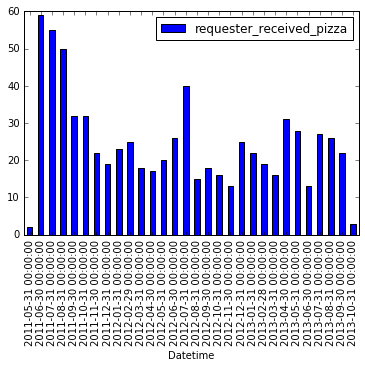

In [16]:
# plot pizzas by month 
%matplotlib inline
unix_index_base = unix_index.drop(['Hour'], axis=1)
month_pizzas = unix_index_base.resample('M').sum()

month_pizzas_bar = month_pizzas.plot(kind='bar')

Statistics of pizza success by hour

count    24.00000
mean     10.75000
std       8.78858
min       0.00000
25%       3.50000
50%       8.50000
75%      16.00000
max      32.00000
Name: requester_received_pizza, dtype: float64


Pizza success by hour of the day


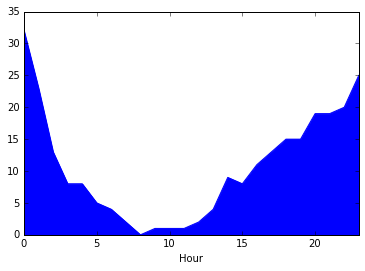

In [28]:
# TIME ANALYSIS - HOUR OF REDDIT POST

# Removed first few months to minimize skew
hourly = unix_index['10/2012':'9/2013'].groupby('Hour')['requester_received_pizza'].sum()
print("Statistics of pizza success by hour\n")
print(hourly.describe())
print("\n\nPizza success by hour of the day")
hourly.plot('area')

# Section 3: Modelling

## Leslie's scoring functions

In [29]:
# Group scoring functions

def roc_curve1(y_true, y_pred_prob):
    """This function plots the ROC curve
    Inputs: y_true, correct label
            y_pred_prob, predicted probabilities
    """
    fpr, tpr, thr = roc_curve(y_true, y_pred_prob)
   
    plt.figure()
    plt.plot(fpr,tpr)
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title("ROC Curve")
    plt.show()
    

def score_rep(y_true, y_pred, desc):
    """Function to print out comprehensive report for classification test
    Inputs: y_true, correct label
            y_pred, predicted label from model
            desc, description of model
    Output: classification report
    """
    print(desc)
    print("-"*75)
    print("Accuracy: ", metrics.accuracy_score(y_true, y_pred))
    print("Area under curve of ROC: ", metrics.roc_auc_score(y_true, y_pred))
    print("Classification report:\n")
    print(metrics.classification_report(y_true, y_pred))
    print("-"*75)

## Section 3.1: Status and Hour LR model


Scoring for Request-retrieval Z-scores and Hour
Accuracy: 0.74
F1 score: 0.0


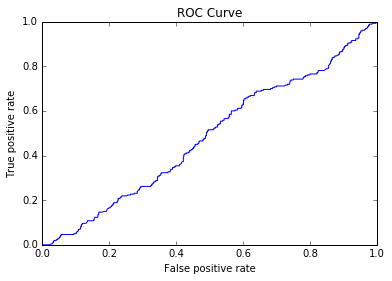

Logistic Regression, C = 0.01
---------------------------------------------------------------------------
Accuracy:  0.74
Area under curve of ROC:  0.5
Classification report:

             precision    recall  f1-score   support

      False       0.74      1.00      0.85       740
       True       0.00      0.00      0.00       260

avg / total       0.55      0.74      0.63      1000

---------------------------------------------------------------------------


In [30]:
import warnings
warnings.filterwarnings('ignore') 

# FOR STATUS AND TIME BY HOUR
lr = LogisticRegression(penalty='l2', C=0.01)

train_labels = np.asarray(allTData['requester_received_pizza'])
dev_labels = np.asarray(allDData['requester_received_pizza'])

# setup training and development datasets
# train
stathourTData = pandas.concat([statusTtrain['Request-Retrieval Z-score'], allTData['unix_timestamp_of_request_utc']], axis=1, 
                              keys=['Request-Retrieval Z-score', 'unix_timestamp_of_request_utc'])
stathourTData['Datetime'] = pandas.to_datetime(stathourTData['unix_timestamp_of_request_utc'], unit='s')
stathourTData['Hour'] = stathourTData['Datetime'].dt.hour
stathourTData_ = stathourTData.drop(['Datetime', 'unix_timestamp_of_request_utc'], axis=1)
# display(stathourTData.head(5))

# development
stathourDData = pandas.concat([statusDtrain['Request-Retrieval Z-score'], allDData['unix_timestamp_of_request_utc']], axis=1, 
                              keys=['Request-Retrieval Z-score', 'unix_timestamp_of_request_utc'])
stathourDData['Datetime'] = pandas.to_datetime(stathourDData['unix_timestamp_of_request_utc'], unit='s')
stathourDData['Hour'] = stathourDData['Datetime'].dt.hour
stathourDData_ = stathourDData.drop(['Datetime', 'unix_timestamp_of_request_utc'], axis=1)
# display(stathourDData.head(5))

# fit LR models
train_stathour_model = lr.fit(stathourTData_, train_labels)
dev_stathour_labels = train_stathour_model.predict(stathourDData_)
stathour_score = train_stathour_model.score(stathourDData_, dev_labels)
stathour_F1score = metrics.f1_score(dev_stathour_labels, dev_labels)

print("\nScoring for Request-retrieval Z-scores and Hour")
print("Accuracy:", stathour_score)
print("F1 score:", stathour_F1score)
roc_curve1(dev_labels, train_stathour_model.predict_proba(stathourDData_)[:,0])
score_rep(dev_labels, dev_stathour_labels,"Logistic Regression, C = 0.01")

## Section 3.1

In [ ]:
# retrieve probabilities from text model where training label is True
text_model = modelLogit.fit(tVector_p, trainLabel)
prob = text_model.predict_proba(dVector_p)
prob_true = [float(y) for x,y in prob]
prob_true = pandas.DataFrame(prob_true)
prob_false = [float(x) for x,y in prob]
prob_false = pandas.DataFrame(prob_false)

# add as a parameter to status/hour dataframe
combinedTData = pandas.concat([stathourTData_, prob_true, prob_false], axis = 1)
combinedDData = stathourDData_

# fit LR models
train_comb_model = lr.fit(combinedTData, train_labels)
dev_comb_labels = train_train_comb_model.predict(combinedDData)
comb_score = train_comb_model.score(combinedDData, dev_labels)
comb_F1score = metrics.f1_score(dev_comb_labels, dev_labels)

print("\nScoring for Request-retrieval Z-scores and bucketed Hour:")
print("Accuracy:", comb_score)
print("F1 score:", comb_F1score)
roc_curve1(dev_labels, train_comb_model.predict_proba(combinedDData)[:,0])
score_rep(dev_labels, dev_comb_labels,"Logistic Regression, C = 0.01")
